<a href="https://colab.research.google.com/github/trevormoon/GAN_study/blob/main/image_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
network.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

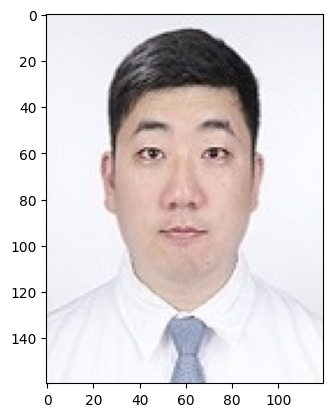

In [ ]:
content_image_path = '/content/sample.jpg'
content_image = tf.keras.preprocessing.image.load_img(content_image_path)
plt.imshow(content_image);

In [ ]:
type(content_image)

PIL.JpegImagePlugin.JpegImageFile

In [ ]:
# Convert PIL image to numpy type to work with TensorFlow
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

type(content_image), content_image.shape, content_image.min(), content_image.max()


(numpy.ndarray, (160, 120, 3), 1.0, 255.0)

In [ ]:
# Normalizing
content_image = content_image / 255

content_image.min(), content_image.max()
content_image = content_image[tf.newaxis, :]
content_image.shape

(1, 160, 120, 3)

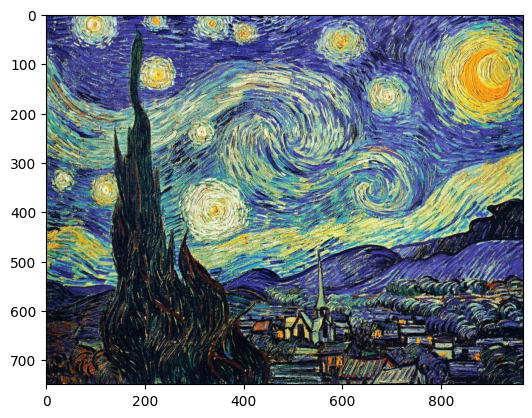

In [ ]:
style_image_path = '/content/style.jpg'
style_image = tf.keras.preprocessing.image.load_img(style_image_path)

plt.imshow(style_image);

In [ ]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]

style_image.shape

(1, 749, 966, 3)

In [ ]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
[network.get_layer(name).output for name in style_layers]

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [ ]:
network.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_3')>

In [ ]:
def build_vgg_layers(layer_names):
    '''return output activation value'''
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    network = tf.keras.Model(inputs=[vgg.input], outputs=outputs)

    return network
# extract image style
style_extractor = build_vgg_layers(style_layers)

In [ ]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [ ]:
# 5 values with ReLU activation are applied
style_outputs = style_extractor(style_image)

style_outputs[0].shape, style_outputs[1].shape, style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape

(TensorShape([1, 749, 966, 64]),
 TensorShape([1, 374, 483, 128]),
 TensorShape([1, 187, 241, 256]),
 TensorShape([1, 93, 120, 512]),
 TensorShape([1, 46, 60, 512]))

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/einsum

# Loss between the style and the content image (see original paper, section 2.2)
def gram_matrix(layer_activation):
    result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    return result / num_locations  # Normalizing


In [ ]:
class StyleContentModel(tf.keras.models.Model):
    '''Build a model that returns the style and content tensors.'''
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = build_vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False  # Because this network won't be trained

    def call(self, inputs):
        inputs = inputs * 255.0  # Denormalizing (Expects float input in [0,1])
        # Data is preprocessed and passed to the VGG (normalized from -127.50 to +127.50)
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

In [ ]:
results = extractor(content_image)

In [ ]:
for key, value in results.items():
    print(key, value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
new_image = tf.Variable(content_image)
optimizer = tf.optimizers.Adam(learning_rate=0.07)

content_weight = 1  # The greater the content weight, the greater the retention of the original image content
style_weight = 1000  # The greater the style weight, the more styles are preserved

num_epochs = 200
verbose = 25

for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        outputs = extractor(new_image)

        content_outputs = outputs['content']
        style_outputs = outputs['style']

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
        content_loss *= content_weight / num_content_layers

        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
        style_loss *= style_weight / num_style_layers

        total_loss = content_loss + style_loss

    gradient = tape.gradient(total_loss, new_image)
    optimizer.apply_gradients([(gradient, new_image)])

    new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

    if (epoch + 1) % verbose == 0:
        print(f'Epoch {epoch + 1} | content loss: {content_loss} | style loss: {style_loss} | total loss {total_loss}')
        plt.imshow(tf.squeeze(new_image, axis=0))
        plt.show()

KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
ax1.imshow(tf.squeeze(content_image, axis=0))
ax1.set_title('Content image')
ax2.imshow(tf.squeeze(new_image, axis=0))
ax2.set_title('New image')
ax3.imshow(tf.squeeze(style_image, axis=0))
ax3.set_title('Style image')
plt.axis('off');